In [13]:
from typing import Optional
import copy
import datetime
import glob
import os
import time
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

from PIL import Image
from skimage import io
from skimage.transform import resize as io_resize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Labeled Data

In [2]:
transforms = {
    'train' : T.Compose([
        T.ToPILImage(),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val' : T.Compose([
        T.ToPILImage(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


class FloodDataset(torch.utils.data.Dataset):
  """
  This is to use with array of files and array of labels as an input
  """
  def __init__(self, X: list[str], y: Optional[list[int]], transform=None):
    self.X = X
    self.y = y
    self.transform = transform
    if y is not None:
       assert len(X) == len(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx: int):
    image = io.imread(self.X[idx])
    if self.transform is not None:
        image = self.transform(image)
    if self.y is None:
        return (image, idx)
    return (image, self.y[idx])

In [3]:
# load dataset
flooded_files = glob.glob("../data/processed/train/labeled/flooded/img/*.jpg")
flooded_y = [1]*len(flooded_files)

non_flooded_files = glob.glob("../data/processed/train/labeled/non-flooded/img/*.jpg")
non_flooded_y = [0]*len(non_flooded_files)

X = flooded_files + non_flooded_files
y = flooded_y + non_flooded_y

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.5, stratify=y)
print(len(X_train), Counter(y_train), len(X_val), Counter(y_val))

199 Counter({0: 173, 1: 26}) 199 Counter({0: 174, 1: 25})


In [4]:
# create sampler
unique_labels, counts = np.unique(y_train, return_counts=True)
class_weights = [1/c for c in counts]
sample_weights = [0] * len(y_train)
for idx, lbl in enumerate(y_train):
    sample_weights[idx] = class_weights[lbl]
sampler_train = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_set = FloodDataset(X_train, y_train, transform=transforms['train'])
val_set = FloodDataset(X_val, y_val, transform=transforms['val'])

BATCH_SIZE = 64
dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler_train),
    'val': torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
}
dataset_size = {
    'train':len(train_set),
    'val':len(val_set),
}

## Load Unlabeled Data

In [5]:
unlabeled_files = glob.glob("../data/processed/train/unlabeled/img/*.jpg")

# Adding validation set to unlabeled data
for mode in ['validation', 'test']:
    unlabeled_files += glob.glob(f"../data/processed/{mode}/img/*.jpg")

unlabeled_files.sort()
pseudo_labels = np.array([-1]*len(unlabeled_files))

unlabeled_set = FloodDataset(unlabeled_files, None, transform=transforms['val'])
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders['unlabeled'] = unlabeled_loader
dataset_size['unlabeled'] = len(unlabeled_set)

## Model

In [6]:
# >>> hyperparameters >>>
lr = 0.01
num_epochs = 100
start_alpha_from = 5
reach_max_alpha_in = 15
# <<< hyperparameters <<<

model = torchvision.models.resnet18(pretrained=True)
final_layer_in = model.fc.in_features
model.fc = torch.nn.Linear(final_layer_in, 2)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters())
scheduler = None

/home/ryotaro/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ryotaro/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train

In [10]:
alphas = np.linspace(0, 1, reach_max_alpha_in - start_alpha_from)

since = time.time()
current_time = datetime.datetime.now()
save_time_prefix = f"{current_time.year}{current_time.month}{current_time.day}_{current_time.hour}{current_time.minute}{current_time.second}"
model_save_path = None

writer = SummaryWriter()
os.makedirs("checkpoints", exist_ok=True)

best_model_wts = copy.deepcopy(model.state_dict())
best_f1 = 0.0

for epoch in range(num_epochs):

    if epoch < start_alpha_from:
        alpha = 0
    elif epoch - start_alpha_from >= len(alphas):
        alpha = alphas[-1]
    else:
        alpha = alphas[max(0,epoch - start_alpha_from)]

    for phase in ['train', 'unlabeled', 'val']:

        if alpha == 0 and phase == 'unlabeled':
            continue
        if phase in ['train', 'unlabeled']:
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # for confusion matrix
        epoch_preds = []
        epoch_lbls = []

        for batch_id, (img, lbl) in enumerate(tqdm(dataloaders[phase], desc=f"Epoch {epoch}/{num_epochs}, {phase}, alpha:{alpha:.2f}")):
            img = img.to(device)
            if phase in ['train', 'val']:
                lbl = lbl.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase in ['train', 'unlabeled']):
                output = model(img)
                preds = torch.argmax(output, 1)

                if phase in ['train', 'val']:
                    loss = criterion(output, lbl)
                else:
                    loss = alpha * criterion(output, torch.tensor(pseudo_labels[lbl], dtype=torch.int64, device=device))

                if phase in ['train', 'val']:
                    epoch_preds.extend(preds.detach().cpu())
                    epoch_lbls.extend(lbl.detach().cpu())

                if phase in ['train', 'unlabeled']:
                    loss.backward()
                    optimizer.step()

            if phase in ['train', 'val']:
                writer.add_scalars(f'Step-Loss/{phase}', {'loss':loss.item(), 'alpha':alpha}, (len(dataloaders[phase])*epoch)+batch_id)
                running_loss += loss.item() * img.size(0)
                running_corrects += torch.sum(preds == lbl.data)

        # if phase in ['train', 'val']:
        #   print(confusion_matrix(epoch_lbls, epoch_preds), np.array([0, 1]))

        if scheduler is not None and phase == 'train':
            scheduler.step()

        if phase in ['train', 'val']:
            epoch_f1 = f1_score(epoch_lbls, epoch_preds)
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

        if phase in ['train', 'val']:
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
            writer.add_scalars(f'F1/{phase}', {'f1':epoch_f1, 'alpha':alpha}, epoch)
            writer.add_scalars(f'Accuracy/{phase}', {'accu':epoch_acc, 'alpha':alpha}, epoch)

        print(f'Epoch {epoch}/{num_epochs}, {phase} Loss: {epoch_loss:.4f}, Acc:{epoch_acc:.4f}, F1:{epoch_f1:.4f}')

        if phase == 'train' and epoch >= start_alpha_from - 1:
            model.eval()
            for img, lbl in tqdm(dataloaders['unlabeled'], desc="Predicting pseudo labels"):
                img = img.to(device)
                preds = torch.argmax(model(img), 1)
                pseudo_labels[lbl] = preds.detach().cpu()

        if phase == 'val' and epoch_f1 > best_f1:
            best_epoch = epoch
            best_f1 = epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())

            if model_save_path:
                os.remove(model_save_path)
            model_save_path = f"checkpoints/{save_time_prefix}_epoch{epoch:03d}_fscore{best_f1:.3f}.pt"

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, model_save_path)

time_elapsed = time.time() - since
writer.close()

torch.save({
    'epoch': num_epochs - 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, f"checkpoints/{save_time_prefix}_last.pt")
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Saved model is from {best_epoch} epoch with f1 {best_f1}')
model.load_state_dict(best_model_wts)

Epoch 0/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Epoch 0/100, train Loss: 0.4011, Acc:0.7990, F1:0.8413


Epoch 0/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]


Epoch 0/100, val Loss: 0.4803, Acc:0.7739, F1:0.4444


Epoch 1/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Epoch 1/100, train Loss: 0.2436, Acc:0.9095, F1:0.9143


Epoch 1/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


Epoch 1/100, val Loss: 0.3852, Acc:0.8442, F1:0.5373


Epoch 2/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch 2/100, train Loss: 0.2121, Acc:0.9246, F1:0.9198


Epoch 2/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]


Epoch 2/100, val Loss: 0.3973, Acc:0.8090, F1:0.4865


Epoch 3/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch 3/100, train Loss: 0.1931, Acc:0.9548, F1:0.9480


Epoch 3/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 3/100, val Loss: 0.2128, Acc:0.9397, F1:0.6842


Epoch 4/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Epoch 4/100, train Loss: 0.1740, Acc:0.9397, F1:0.9333


Epoch 4/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 13.40it/s]


Epoch 4/100, val Loss: 0.2223, Acc:0.9347, F1:0.6977


Epoch 5/100, train, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Epoch 5/100, train Loss: 0.1967, Acc:0.9246, F1:0.9315


Epoch 5/100, val, alpha:0.00: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 5/100, val Loss: 0.2760, Acc:0.9196, F1:0.6800


Epoch 6/100, train, alpha:0.11: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Epoch 6/100, train Loss: 0.1637, Acc:0.9497, F1:0.9438


Epoch 6/100, unlabeled, alpha:0.11: 100%|██████████| 31/31 [00:03<00:00,  8.31it/s]


Epoch 6/100, unlabeled Loss: 0.1637, Acc:0.9497, F1:0.9438


Epoch 6/100, val, alpha:0.11: 100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Epoch 6/100, val Loss: 0.2098, Acc:0.9397, F1:0.6842


Epoch 7/100, train, alpha:0.22: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Epoch 7/100, train Loss: 0.2249, Acc:0.9196, F1:0.9048


Epoch 7/100, unlabeled, alpha:0.22: 100%|██████████| 31/31 [00:03<00:00,  8.33it/s]


Epoch 7/100, unlabeled Loss: 0.2249, Acc:0.9196, F1:0.9048


Epoch 7/100, val, alpha:0.22: 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


Epoch 7/100, val Loss: 0.2276, Acc:0.9397, F1:0.7391


Epoch 8/100, train, alpha:0.33: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Epoch 8/100, train Loss: 0.1620, Acc:0.9447, F1:0.9357


Epoch 8/100, unlabeled, alpha:0.33: 100%|██████████| 31/31 [00:03<00:00,  8.27it/s]


Epoch 8/100, unlabeled Loss: 0.1620, Acc:0.9447, F1:0.9357


Epoch 8/100, val, alpha:0.33: 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


Epoch 8/100, val Loss: 0.2039, Acc:0.9347, F1:0.6667


Epoch 9/100, train, alpha:0.44: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


Epoch 9/100, train Loss: 0.1620, Acc:0.9548, F1:0.9514


Epoch 9/100, unlabeled, alpha:0.44: 100%|██████████| 31/31 [00:03<00:00,  8.27it/s]


Epoch 9/100, unlabeled Loss: 0.1620, Acc:0.9548, F1:0.9514


Epoch 9/100, val, alpha:0.44: 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]


Epoch 9/100, val Loss: 0.2011, Acc:0.9497, F1:0.7727


Epoch 10/100, train, alpha:0.56: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch 10/100, train Loss: 0.3170, Acc:0.9095, F1:0.9062


Epoch 10/100, unlabeled, alpha:0.56: 100%|██████████| 31/31 [00:03<00:00,  8.21it/s]


Epoch 10/100, unlabeled Loss: 0.3170, Acc:0.9095, F1:0.9062


Epoch 10/100, val, alpha:0.56: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]


Epoch 10/100, val Loss: 0.2051, Acc:0.9497, F1:0.7727


Epoch 11/100, train, alpha:0.67: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Epoch 11/100, train Loss: 0.1087, Acc:0.9698, F1:0.9677


Epoch 11/100, unlabeled, alpha:0.67: 100%|██████████| 31/31 [00:03<00:00,  8.21it/s]


Epoch 11/100, unlabeled Loss: 0.1087, Acc:0.9698, F1:0.9677


Epoch 11/100, val, alpha:0.67: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 11/100, val Loss: 0.2556, Acc:0.9196, F1:0.6800


Epoch 12/100, train, alpha:0.78: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Epoch 12/100, train Loss: 0.1503, Acc:0.9347, F1:0.9240


Epoch 12/100, unlabeled, alpha:0.78: 100%|██████████| 31/31 [00:03<00:00,  8.22it/s]


Epoch 12/100, unlabeled Loss: 0.1503, Acc:0.9347, F1:0.9240


Epoch 12/100, val, alpha:0.78: 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


Epoch 12/100, val Loss: 0.2305, Acc:0.9246, F1:0.6939


Epoch 13/100, train, alpha:0.89: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


Epoch 13/100, train Loss: 0.1616, Acc:0.9347, F1:0.9249


Epoch 13/100, unlabeled, alpha:0.89: 100%|██████████| 31/31 [00:03<00:00,  8.18it/s]


Epoch 13/100, unlabeled Loss: 0.1616, Acc:0.9347, F1:0.9249


Epoch 13/100, val, alpha:0.89: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


Epoch 13/100, val Loss: 0.2527, Acc:0.9347, F1:0.7234


Epoch 14/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch 14/100, train Loss: 0.1018, Acc:0.9799, F1:0.9802


Epoch 14/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 14/100, unlabeled Loss: 0.1018, Acc:0.9799, F1:0.9802


Epoch 14/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Epoch 14/100, val Loss: 0.2756, Acc:0.9196, F1:0.6800


Epoch 15/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch 15/100, train Loss: 0.1019, Acc:0.9648, F1:0.9595


Epoch 15/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.10it/s]


Epoch 15/100, unlabeled Loss: 0.1019, Acc:0.9648, F1:0.9595


Epoch 15/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Epoch 15/100, val Loss: 0.2586, Acc:0.9296, F1:0.7083


Epoch 16/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch 16/100, train Loss: 0.1135, Acc:0.9548, F1:0.9524


Epoch 16/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 16/100, unlabeled Loss: 0.1135, Acc:0.9548, F1:0.9524


Epoch 16/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Epoch 16/100, val Loss: 0.2430, Acc:0.9397, F1:0.7391


Epoch 17/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Epoch 17/100, train Loss: 0.1329, Acc:0.9548, F1:0.9529


Epoch 17/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 17/100, unlabeled Loss: 0.1329, Acc:0.9548, F1:0.9529


Epoch 17/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.98it/s]


Epoch 17/100, val Loss: 0.2534, Acc:0.9246, F1:0.6939


Epoch 18/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 18/100, train Loss: 0.1268, Acc:0.9548, F1:0.9538


Epoch 18/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 18/100, unlabeled Loss: 0.1268, Acc:0.9548, F1:0.9538


Epoch 18/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 18/100, val Loss: 0.3645, Acc:0.8844, F1:0.6230


Epoch 19/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Epoch 19/100, train Loss: 0.0555, Acc:0.9799, F1:0.9808


Epoch 19/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 19/100, unlabeled Loss: 0.0555, Acc:0.9799, F1:0.9808


Epoch 19/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]


Epoch 19/100, val Loss: 0.2771, Acc:0.9246, F1:0.6939


Epoch 20/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch 20/100, train Loss: 0.0700, Acc:0.9799, F1:0.9813


Epoch 20/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 20/100, unlabeled Loss: 0.0700, Acc:0.9799, F1:0.9813


Epoch 20/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Epoch 20/100, val Loss: 0.2793, Acc:0.9246, F1:0.6939


Epoch 21/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


Epoch 21/100, train Loss: 0.0314, Acc:0.9899, F1:0.9892


Epoch 21/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 21/100, unlabeled Loss: 0.0314, Acc:0.9899, F1:0.9892


Epoch 21/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Epoch 21/100, val Loss: 0.2822, Acc:0.9296, F1:0.7083


Epoch 22/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 22/100, train Loss: 0.0304, Acc:0.9899, F1:0.9892


Epoch 22/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 22/100, unlabeled Loss: 0.0304, Acc:0.9899, F1:0.9892


Epoch 22/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 22/100, val Loss: 0.2975, Acc:0.9246, F1:0.6939


Epoch 23/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 23/100, train Loss: 0.0268, Acc:1.0000, F1:1.0000


Epoch 23/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 23/100, unlabeled Loss: 0.0268, Acc:1.0000, F1:1.0000


Epoch 23/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]


Epoch 23/100, val Loss: 0.3114, Acc:0.9296, F1:0.7083


Epoch 24/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


Epoch 24/100, train Loss: 0.2149, Acc:0.9246, F1:0.9327


Epoch 24/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 24/100, unlabeled Loss: 0.2149, Acc:0.9246, F1:0.9327


Epoch 24/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 24/100, val Loss: 0.3312, Acc:0.9146, F1:0.6909


Epoch 25/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 25/100, train Loss: 0.0430, Acc:0.9749, F1:0.9763


Epoch 25/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 25/100, unlabeled Loss: 0.0430, Acc:0.9749, F1:0.9763


Epoch 25/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]


Epoch 25/100, val Loss: 0.3059, Acc:0.9246, F1:0.6939


Epoch 26/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 26/100, train Loss: 0.0295, Acc:0.9950, F1:0.9948


Epoch 26/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 26/100, unlabeled Loss: 0.0295, Acc:0.9950, F1:0.9948


Epoch 26/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.58it/s]


Epoch 26/100, val Loss: 0.3105, Acc:0.9246, F1:0.6939


Epoch 27/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch 27/100, train Loss: 0.0231, Acc:1.0000, F1:1.0000


Epoch 27/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 27/100, unlabeled Loss: 0.0231, Acc:1.0000, F1:1.0000


Epoch 27/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.56it/s]


Epoch 27/100, val Loss: 0.3178, Acc:0.9296, F1:0.7083


Epoch 28/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch 28/100, train Loss: 0.0181, Acc:1.0000, F1:1.0000


Epoch 28/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 28/100, unlabeled Loss: 0.0181, Acc:1.0000, F1:1.0000


Epoch 28/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


Epoch 28/100, val Loss: 0.3311, Acc:0.9196, F1:0.6800


Epoch 29/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Epoch 29/100, train Loss: 0.0723, Acc:0.9749, F1:0.9751


Epoch 29/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 29/100, unlabeled Loss: 0.0723, Acc:0.9749, F1:0.9751


Epoch 29/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.87it/s]


Epoch 29/100, val Loss: 0.3399, Acc:0.9246, F1:0.6939


Epoch 30/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Epoch 30/100, train Loss: 0.0224, Acc:0.9950, F1:0.9945


Epoch 30/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 30/100, unlabeled Loss: 0.0224, Acc:0.9950, F1:0.9945


Epoch 30/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]


Epoch 30/100, val Loss: 0.3241, Acc:0.9196, F1:0.6923


Epoch 31/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


Epoch 31/100, train Loss: 0.0283, Acc:1.0000, F1:1.0000


Epoch 31/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 31/100, unlabeled Loss: 0.0283, Acc:1.0000, F1:1.0000


Epoch 31/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.61it/s]


Epoch 31/100, val Loss: 0.3477, Acc:0.9146, F1:0.6792


Epoch 32/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch 32/100, train Loss: 0.0069, Acc:1.0000, F1:1.0000


Epoch 32/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 32/100, unlabeled Loss: 0.0069, Acc:1.0000, F1:1.0000


Epoch 32/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]


Epoch 32/100, val Loss: 0.3410, Acc:0.9246, F1:0.7059


Epoch 33/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


Epoch 33/100, train Loss: 0.0105, Acc:1.0000, F1:1.0000


Epoch 33/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 33/100, unlabeled Loss: 0.0105, Acc:1.0000, F1:1.0000


Epoch 33/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]


Epoch 33/100, val Loss: 0.3442, Acc:0.9246, F1:0.7059


Epoch 34/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Epoch 34/100, train Loss: 0.0122, Acc:0.9950, F1:0.9948


Epoch 34/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 34/100, unlabeled Loss: 0.0122, Acc:0.9950, F1:0.9948


Epoch 34/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.83it/s]


Epoch 34/100, val Loss: 0.3585, Acc:0.9246, F1:0.7059


Epoch 35/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 35/100, train Loss: 0.0143, Acc:0.9950, F1:0.9950


Epoch 35/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 35/100, unlabeled Loss: 0.0143, Acc:0.9950, F1:0.9950


Epoch 35/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]


Epoch 35/100, val Loss: 0.3551, Acc:0.9296, F1:0.7200


Epoch 36/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Epoch 36/100, train Loss: 0.0152, Acc:1.0000, F1:1.0000


Epoch 36/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 36/100, unlabeled Loss: 0.0152, Acc:1.0000, F1:1.0000


Epoch 36/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Epoch 36/100, val Loss: 0.3678, Acc:0.9196, F1:0.6923


Epoch 37/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Epoch 37/100, train Loss: 0.0061, Acc:1.0000, F1:1.0000


Epoch 37/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


Epoch 37/100, unlabeled Loss: 0.0061, Acc:1.0000, F1:1.0000


Epoch 37/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


Epoch 37/100, val Loss: 0.3704, Acc:0.9196, F1:0.6923


Epoch 38/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Epoch 38/100, train Loss: 0.0853, Acc:0.9799, F1:0.9775


Epoch 38/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 38/100, unlabeled Loss: 0.0853, Acc:0.9799, F1:0.9775


Epoch 38/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Epoch 38/100, val Loss: 1.9846, Acc:0.5829, F1:0.3360


Epoch 39/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Epoch 39/100, train Loss: 0.0676, Acc:0.9749, F1:0.9756


Epoch 39/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.03it/s]


Epoch 39/100, unlabeled Loss: 0.0676, Acc:0.9749, F1:0.9756


Epoch 39/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]


Epoch 39/100, val Loss: 1.1676, Acc:0.7739, F1:0.4828


Epoch 40/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


Epoch 40/100, train Loss: 0.0278, Acc:0.9799, F1:0.9789


Epoch 40/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 40/100, unlabeled Loss: 0.0278, Acc:0.9799, F1:0.9789


Epoch 40/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Epoch 40/100, val Loss: 0.5624, Acc:0.8894, F1:0.6207


Epoch 41/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch 41/100, train Loss: 0.0091, Acc:0.9950, F1:0.9950


Epoch 41/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 41/100, unlabeled Loss: 0.0091, Acc:0.9950, F1:0.9950


Epoch 41/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 41/100, val Loss: 0.4910, Acc:0.8995, F1:0.6296


Epoch 42/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Epoch 42/100, train Loss: 0.0060, Acc:1.0000, F1:1.0000


Epoch 42/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 42/100, unlabeled Loss: 0.0060, Acc:1.0000, F1:1.0000


Epoch 42/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 42/100, val Loss: 0.4451, Acc:0.9095, F1:0.6667


Epoch 43/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch 43/100, train Loss: 0.0178, Acc:0.9899, F1:0.9899


Epoch 43/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 43/100, unlabeled Loss: 0.0178, Acc:0.9899, F1:0.9899


Epoch 43/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.97it/s]


Epoch 43/100, val Loss: 0.4176, Acc:0.9146, F1:0.6792


Epoch 44/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch 44/100, train Loss: 0.0437, Acc:0.9950, F1:0.9952


Epoch 44/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 44/100, unlabeled Loss: 0.0437, Acc:0.9950, F1:0.9952


Epoch 44/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.09it/s]


Epoch 44/100, val Loss: 0.3357, Acc:0.9347, F1:0.7347


Epoch 45/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 45/100, train Loss: 0.0136, Acc:1.0000, F1:1.0000


Epoch 45/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 45/100, unlabeled Loss: 0.0136, Acc:1.0000, F1:1.0000


Epoch 45/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


Epoch 45/100, val Loss: 0.3204, Acc:0.9296, F1:0.7200


Epoch 46/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch 46/100, train Loss: 0.0068, Acc:1.0000, F1:1.0000


Epoch 46/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 46/100, unlabeled Loss: 0.0068, Acc:1.0000, F1:1.0000


Epoch 46/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 10.88it/s]


Epoch 46/100, val Loss: 0.3108, Acc:0.9397, F1:0.7500


Epoch 47/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


Epoch 47/100, train Loss: 0.0065, Acc:1.0000, F1:1.0000


Epoch 47/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 47/100, unlabeled Loss: 0.0065, Acc:1.0000, F1:1.0000


Epoch 47/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]


Epoch 47/100, val Loss: 0.3127, Acc:0.9397, F1:0.7500


Epoch 48/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch 48/100, train Loss: 0.0112, Acc:1.0000, F1:1.0000


Epoch 48/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 48/100, unlabeled Loss: 0.0112, Acc:1.0000, F1:1.0000


Epoch 48/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Epoch 48/100, val Loss: 0.3299, Acc:0.9397, F1:0.7500


Epoch 49/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Epoch 49/100, train Loss: 0.0159, Acc:0.9950, F1:0.9952


Epoch 49/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 49/100, unlabeled Loss: 0.0159, Acc:0.9950, F1:0.9952


Epoch 49/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]


Epoch 49/100, val Loss: 0.3213, Acc:0.9447, F1:0.7660


Epoch 50/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch 50/100, train Loss: 0.0531, Acc:0.9899, F1:0.9902


Epoch 50/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 50/100, unlabeled Loss: 0.0531, Acc:0.9899, F1:0.9902


Epoch 50/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.02it/s]


Epoch 50/100, val Loss: 0.3523, Acc:0.9447, F1:0.7660


Epoch 51/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 51/100, train Loss: 0.0142, Acc:0.9950, F1:0.9949


Epoch 51/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 51/100, unlabeled Loss: 0.0142, Acc:0.9950, F1:0.9949


Epoch 51/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Epoch 51/100, val Loss: 0.3523, Acc:0.9497, F1:0.7826


Epoch 52/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


Epoch 52/100, train Loss: 0.0075, Acc:1.0000, F1:1.0000


Epoch 52/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.10it/s]


Epoch 52/100, unlabeled Loss: 0.0075, Acc:1.0000, F1:1.0000


Epoch 52/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.06it/s]


Epoch 52/100, val Loss: 0.3559, Acc:0.9497, F1:0.7826


Epoch 53/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch 53/100, train Loss: 0.0058, Acc:1.0000, F1:1.0000


Epoch 53/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 53/100, unlabeled Loss: 0.0058, Acc:1.0000, F1:1.0000


Epoch 53/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]


Epoch 53/100, val Loss: 0.3560, Acc:0.9497, F1:0.7826


Epoch 54/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch 54/100, train Loss: 0.0123, Acc:0.9950, F1:0.9951


Epoch 54/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 54/100, unlabeled Loss: 0.0123, Acc:0.9950, F1:0.9951


Epoch 54/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Epoch 54/100, val Loss: 0.4249, Acc:0.9497, F1:0.7826


Epoch 55/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 55/100, train Loss: 0.0337, Acc:0.9899, F1:0.9899


Epoch 55/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 55/100, unlabeled Loss: 0.0337, Acc:0.9899, F1:0.9899


Epoch 55/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Epoch 55/100, val Loss: 0.3379, Acc:0.9397, F1:0.7500


Epoch 56/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 56/100, train Loss: 0.0010, Acc:1.0000, F1:1.0000


Epoch 56/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 56/100, unlabeled Loss: 0.0010, Acc:1.0000, F1:1.0000


Epoch 56/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Epoch 56/100, val Loss: 0.3383, Acc:0.9447, F1:0.7660


Epoch 57/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 57/100, train Loss: 0.0032, Acc:1.0000, F1:1.0000


Epoch 57/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


Epoch 57/100, unlabeled Loss: 0.0032, Acc:1.0000, F1:1.0000


Epoch 57/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]


Epoch 57/100, val Loss: 0.3465, Acc:0.9447, F1:0.7660


Epoch 58/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 58/100, train Loss: 0.0193, Acc:0.9849, F1:0.9838


Epoch 58/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 58/100, unlabeled Loss: 0.0193, Acc:0.9849, F1:0.9838


Epoch 58/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


Epoch 58/100, val Loss: 0.4007, Acc:0.9095, F1:0.6667


Epoch 59/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


Epoch 59/100, train Loss: 0.0123, Acc:0.9950, F1:0.9950


Epoch 59/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 59/100, unlabeled Loss: 0.0123, Acc:0.9950, F1:0.9950


Epoch 59/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.49it/s]


Epoch 59/100, val Loss: 0.3721, Acc:0.9347, F1:0.7347


Epoch 60/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 60/100, train Loss: 0.0077, Acc:1.0000, F1:1.0000


Epoch 60/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.08it/s]


Epoch 60/100, unlabeled Loss: 0.0077, Acc:1.0000, F1:1.0000


Epoch 60/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


Epoch 60/100, val Loss: 0.3555, Acc:0.9447, F1:0.7660


Epoch 61/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 61/100, train Loss: 0.0381, Acc:0.9899, F1:0.9891


Epoch 61/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 61/100, unlabeled Loss: 0.0381, Acc:0.9899, F1:0.9891


Epoch 61/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 61/100, val Loss: 0.3902, Acc:0.9447, F1:0.7442


Epoch 62/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Epoch 62/100, train Loss: 0.0387, Acc:0.9899, F1:0.9900


Epoch 62/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


Epoch 62/100, unlabeled Loss: 0.0387, Acc:0.9899, F1:0.9900


Epoch 62/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]


Epoch 62/100, val Loss: 0.3649, Acc:0.9497, F1:0.7727


Epoch 63/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 63/100, train Loss: 0.0260, Acc:0.9950, F1:0.9950


Epoch 63/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 63/100, unlabeled Loss: 0.0260, Acc:0.9950, F1:0.9950


Epoch 63/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Epoch 63/100, val Loss: 0.3856, Acc:0.9497, F1:0.7727


Epoch 64/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Epoch 64/100, train Loss: 0.0102, Acc:1.0000, F1:1.0000


Epoch 64/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 64/100, unlabeled Loss: 0.0102, Acc:1.0000, F1:1.0000


Epoch 64/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Epoch 64/100, val Loss: 0.3959, Acc:0.9497, F1:0.7727


Epoch 65/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Epoch 65/100, train Loss: 0.0165, Acc:1.0000, F1:1.0000


Epoch 65/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.05it/s]


Epoch 65/100, unlabeled Loss: 0.0165, Acc:1.0000, F1:1.0000


Epoch 65/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 65/100, val Loss: 0.3806, Acc:0.9497, F1:0.7727


Epoch 66/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 66/100, train Loss: 0.0205, Acc:0.9950, F1:0.9955


Epoch 66/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 66/100, unlabeled Loss: 0.0205, Acc:0.9950, F1:0.9955


Epoch 66/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]


Epoch 66/100, val Loss: 0.3861, Acc:0.9497, F1:0.7727


Epoch 67/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


Epoch 67/100, train Loss: 0.0181, Acc:1.0000, F1:1.0000


Epoch 67/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 67/100, unlabeled Loss: 0.0181, Acc:1.0000, F1:1.0000


Epoch 67/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


Epoch 67/100, val Loss: 0.3876, Acc:0.9497, F1:0.7727


Epoch 68/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 68/100, train Loss: 0.0073, Acc:1.0000, F1:1.0000


Epoch 68/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 68/100, unlabeled Loss: 0.0073, Acc:1.0000, F1:1.0000


Epoch 68/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]


Epoch 68/100, val Loss: 0.4018, Acc:0.9497, F1:0.7727


Epoch 69/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Epoch 69/100, train Loss: 0.0095, Acc:0.9950, F1:0.9947


Epoch 69/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 69/100, unlabeled Loss: 0.0095, Acc:0.9950, F1:0.9947


Epoch 69/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]


Epoch 69/100, val Loss: 0.3943, Acc:0.9347, F1:0.7234


Epoch 70/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Epoch 70/100, train Loss: 0.0153, Acc:0.9899, F1:0.9904


Epoch 70/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 70/100, unlabeled Loss: 0.0153, Acc:0.9899, F1:0.9904


Epoch 70/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]


Epoch 70/100, val Loss: 0.3628, Acc:0.9447, F1:0.7556


Epoch 71/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


Epoch 71/100, train Loss: 0.0030, Acc:1.0000, F1:1.0000


Epoch 71/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 71/100, unlabeled Loss: 0.0030, Acc:1.0000, F1:1.0000


Epoch 71/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 71/100, val Loss: 0.3396, Acc:0.9447, F1:0.7556


Epoch 72/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch 72/100, train Loss: 0.0052, Acc:1.0000, F1:1.0000


Epoch 72/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 72/100, unlabeled Loss: 0.0052, Acc:1.0000, F1:1.0000


Epoch 72/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.60it/s]


Epoch 72/100, val Loss: 0.3454, Acc:0.9447, F1:0.7556


Epoch 73/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 73/100, train Loss: 0.0041, Acc:1.0000, F1:1.0000


Epoch 73/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 73/100, unlabeled Loss: 0.0041, Acc:1.0000, F1:1.0000


Epoch 73/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Epoch 73/100, val Loss: 0.3428, Acc:0.9447, F1:0.7556


Epoch 74/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Epoch 74/100, train Loss: 0.0046, Acc:1.0000, F1:1.0000


Epoch 74/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 74/100, unlabeled Loss: 0.0046, Acc:1.0000, F1:1.0000


Epoch 74/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 74/100, val Loss: 0.3475, Acc:0.9447, F1:0.7556


Epoch 75/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Epoch 75/100, train Loss: 0.0358, Acc:0.9950, F1:0.9950


Epoch 75/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 75/100, unlabeled Loss: 0.0358, Acc:0.9950, F1:0.9950


Epoch 75/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]


Epoch 75/100, val Loss: 0.3561, Acc:0.9497, F1:0.7826


Epoch 76/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 76/100, train Loss: 0.0206, Acc:0.9950, F1:0.9953


Epoch 76/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 76/100, unlabeled Loss: 0.0206, Acc:0.9950, F1:0.9953


Epoch 76/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]


Epoch 76/100, val Loss: 0.3539, Acc:0.9497, F1:0.7826


Epoch 77/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch 77/100, train Loss: 0.0264, Acc:0.9849, F1:0.9851


Epoch 77/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


Epoch 77/100, unlabeled Loss: 0.0264, Acc:0.9849, F1:0.9851


Epoch 77/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Epoch 77/100, val Loss: 0.3759, Acc:0.9548, F1:0.8000


Epoch 78/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


Epoch 78/100, train Loss: 0.0084, Acc:0.9950, F1:0.9947


Epoch 78/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.10it/s]


Epoch 78/100, unlabeled Loss: 0.0084, Acc:0.9950, F1:0.9947


Epoch 78/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.10it/s]


Epoch 78/100, val Loss: 0.3645, Acc:0.9548, F1:0.8000


Epoch 79/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch 79/100, train Loss: 0.0150, Acc:0.9950, F1:0.9949


Epoch 79/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.10it/s]


Epoch 79/100, unlabeled Loss: 0.0150, Acc:0.9950, F1:0.9949


Epoch 79/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.43it/s]


Epoch 79/100, val Loss: 0.3820, Acc:0.9548, F1:0.8000


Epoch 80/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


Epoch 80/100, train Loss: 0.0074, Acc:0.9950, F1:0.9956


Epoch 80/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 80/100, unlabeled Loss: 0.0074, Acc:0.9950, F1:0.9956


Epoch 80/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.29it/s]


Epoch 80/100, val Loss: 0.3827, Acc:0.9548, F1:0.8000


Epoch 81/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s]


Epoch 81/100, train Loss: 0.0034, Acc:1.0000, F1:1.0000


Epoch 81/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 81/100, unlabeled Loss: 0.0034, Acc:1.0000, F1:1.0000


Epoch 81/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.29it/s]


Epoch 81/100, val Loss: 0.3743, Acc:0.9548, F1:0.8000


Epoch 82/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Epoch 82/100, train Loss: 0.0043, Acc:1.0000, F1:1.0000


Epoch 82/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 82/100, unlabeled Loss: 0.0043, Acc:1.0000, F1:1.0000


Epoch 82/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.97it/s]


Epoch 82/100, val Loss: 0.3773, Acc:0.9548, F1:0.8000


Epoch 83/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 83/100, train Loss: 0.0023, Acc:1.0000, F1:1.0000


Epoch 83/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 83/100, unlabeled Loss: 0.0023, Acc:1.0000, F1:1.0000


Epoch 83/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Epoch 83/100, val Loss: 0.3683, Acc:0.9548, F1:0.8000


Epoch 84/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch 84/100, train Loss: 0.0015, Acc:1.0000, F1:1.0000


Epoch 84/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.11it/s]


Epoch 84/100, unlabeled Loss: 0.0015, Acc:1.0000, F1:1.0000


Epoch 84/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]


Epoch 84/100, val Loss: 0.3777, Acc:0.9548, F1:0.8000


Epoch 85/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch 85/100, train Loss: 0.0034, Acc:1.0000, F1:1.0000


Epoch 85/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 85/100, unlabeled Loss: 0.0034, Acc:1.0000, F1:1.0000


Epoch 85/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]


Epoch 85/100, val Loss: 0.3810, Acc:0.9548, F1:0.8000


Epoch 86/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Epoch 86/100, train Loss: 0.0024, Acc:1.0000, F1:1.0000


Epoch 86/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 86/100, unlabeled Loss: 0.0024, Acc:1.0000, F1:1.0000


Epoch 86/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.82it/s]


Epoch 86/100, val Loss: 0.3777, Acc:0.9548, F1:0.8000


Epoch 87/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Epoch 87/100, train Loss: 0.0027, Acc:1.0000, F1:1.0000


Epoch 87/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 87/100, unlabeled Loss: 0.0027, Acc:1.0000, F1:1.0000


Epoch 87/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.62it/s]


Epoch 87/100, val Loss: 0.3886, Acc:0.9548, F1:0.8000


Epoch 88/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Epoch 88/100, train Loss: 0.0014, Acc:1.0000, F1:1.0000


Epoch 88/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 88/100, unlabeled Loss: 0.0014, Acc:1.0000, F1:1.0000


Epoch 88/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


Epoch 88/100, val Loss: 0.3811, Acc:0.9548, F1:0.8000


Epoch 89/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 89/100, train Loss: 0.0011, Acc:1.0000, F1:1.0000


Epoch 89/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 89/100, unlabeled Loss: 0.0011, Acc:1.0000, F1:1.0000


Epoch 89/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.77it/s]


Epoch 89/100, val Loss: 0.3760, Acc:0.9548, F1:0.8000


Epoch 90/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Epoch 90/100, train Loss: 0.0046, Acc:1.0000, F1:1.0000


Epoch 90/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.00it/s]


Epoch 90/100, unlabeled Loss: 0.0046, Acc:1.0000, F1:1.0000


Epoch 90/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.41it/s]


Epoch 90/100, val Loss: 0.3761, Acc:0.9548, F1:0.8000


Epoch 91/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Epoch 91/100, train Loss: 0.2721, Acc:0.9648, F1:0.9622


Epoch 91/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.15it/s]


Epoch 91/100, unlabeled Loss: 0.2721, Acc:0.9648, F1:0.9622


Epoch 91/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]


Epoch 91/100, val Loss: 0.9784, Acc:0.7487, F1:0.4444


Epoch 92/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Epoch 92/100, train Loss: 0.0314, Acc:0.9849, F1:0.9862


Epoch 92/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.08it/s]


Epoch 92/100, unlabeled Loss: 0.0314, Acc:0.9849, F1:0.9862


Epoch 92/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Epoch 92/100, val Loss: 0.8653, Acc:0.7940, F1:0.4810


Epoch 93/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 93/100, train Loss: 0.0089, Acc:0.9950, F1:0.9951


Epoch 93/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 93/100, unlabeled Loss: 0.0089, Acc:0.9950, F1:0.9951


Epoch 93/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.36it/s]


Epoch 93/100, val Loss: 0.6871, Acc:0.8693, F1:0.5806


Epoch 94/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Epoch 94/100, train Loss: 0.0184, Acc:0.9950, F1:0.9953


Epoch 94/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 94/100, unlabeled Loss: 0.0184, Acc:0.9950, F1:0.9953


Epoch 94/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Epoch 94/100, val Loss: 0.5257, Acc:0.9095, F1:0.6667


Epoch 95/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


Epoch 95/100, train Loss: 0.0016, Acc:1.0000, F1:1.0000


Epoch 95/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 95/100, unlabeled Loss: 0.0016, Acc:1.0000, F1:1.0000


Epoch 95/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


Epoch 95/100, val Loss: 0.5070, Acc:0.8945, F1:0.6316


Epoch 96/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


Epoch 96/100, train Loss: 0.0096, Acc:0.9950, F1:0.9952


Epoch 96/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.06it/s]


Epoch 96/100, unlabeled Loss: 0.0096, Acc:0.9950, F1:0.9952


Epoch 96/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]


Epoch 96/100, val Loss: 0.4152, Acc:0.9246, F1:0.7059


Epoch 97/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch 97/100, train Loss: 0.0020, Acc:1.0000, F1:1.0000


Epoch 97/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.13it/s]


Epoch 97/100, unlabeled Loss: 0.0020, Acc:1.0000, F1:1.0000


Epoch 97/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 97/100, val Loss: 0.4209, Acc:0.9196, F1:0.6923


Epoch 98/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Epoch 98/100, train Loss: 0.0017, Acc:1.0000, F1:1.0000


Epoch 98/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.14it/s]


Epoch 98/100, unlabeled Loss: 0.0017, Acc:1.0000, F1:1.0000


Epoch 98/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]


Epoch 98/100, val Loss: 0.4128, Acc:0.9296, F1:0.7200


Epoch 99/100, train, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 99/100, train Loss: 0.0021, Acc:1.0000, F1:1.0000


Epoch 99/100, unlabeled, alpha:1.00: 100%|██████████| 31/31 [00:03<00:00,  8.12it/s]


Epoch 99/100, unlabeled Loss: 0.0021, Acc:1.0000, F1:1.0000


Epoch 99/100, val, alpha:1.00: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]


Epoch 99/100, val Loss: 0.4110, Acc:0.9397, F1:0.7391
Training complete in 12m 36s
Saved model is from 77 epoch with f1 0.8


<All keys matched successfully>

## Test

Not-Flooded


/tmp/ipykernel_1853435/1418463715.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_wts = torch.load(model_save_path)


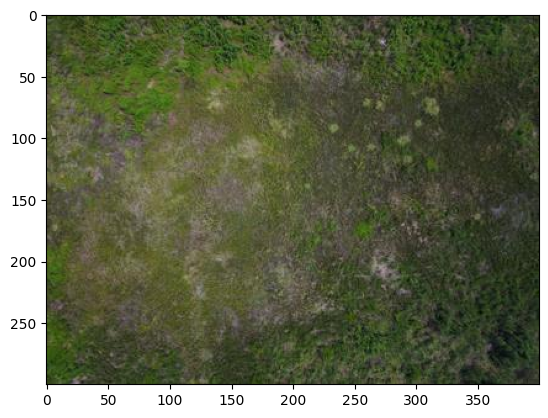

In [18]:
best_model_wts = torch.load(model_save_path)
model.load_state_dict(best_model_wts["model_state_dict"])

fname = "../data/processed/validation/img/8058.jpg"
classes = {0:'Not-Flooded', 1:'Flooded'}
test_img = np.array(Image.open(fname))
test_img_t = transforms['val'](test_img).unsqueeze(0)

model.eval()
with torch.no_grad():
    pred = torch.argmax(model(test_img_t.to(device))).detach().cpu().item()
print(classes[pred])

plt.imshow(test_img)

In [17]:
pred

0